In [2]:
# import of standard python packages and flopy
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5, 4) # default figure size
plt.rcParams["figure.autolayout"] = True # same as tight_layout after every plot
import flopy as fp # import flopy and call it fp

In [114]:
# Model domain
Lx = 330 # West-East length of domain, m
Ly = 140 # North-South length of domain, m

# Layers
nlay = 1#3 # number of layers
top = -1 # top of top unconfined layer, m
botm = [-8]#[0, -5, -25] # list with bottom of each layer, same everywhere, m

# Aquifer properties
k_hor = 1#[30, 0.1, 50] # horizontal hydraulic conductivity for each layer, m/d
k_ver = 0#[20, 0.01, 5] # vertical hydraulic conductivity for each layer, m/d

# Boundary conditions
recharge_0 = 0 # m/d (0.5 mm/d), # positive for putting into the aquifer
recharge_1 = 1e-3
# Grid properties
ncol = 33 # number of columns
nrow = 14 # number of rows
delc = Ly / nrow # cell size in column direction
delr = Lx / ncol # cell size in row direction

#constant boundary
h0_boundary = -0.3 #head along the boundary fixed, m, before
h1_boundary = -0.45 #head along the boundary fixed, m, adjusted

In [115]:
def gw_model2D(h, N):

    # Define name and path
    modelname = 'model_callant' # model name to be used
    modelws = './model_m_callant' # model work space to be used
    path = os.getcwd() # path to current working directory

    # Create simulation
    sim = fp.mf6.MFSimulation(sim_name=modelname, # name of simulation
                              version='mf6', # version of MODFLOW
                              exe_name=os.path.abspath('bin/mf6.exe'), # absolute path to MODFLOW executable
                              sim_ws=modelws, # path to workspace where all files are stored
                             )

    # Time discretization
    tdis = fp.mf6.ModflowTdis(simulation=sim, # add to the simulation called sim (defined in prevous code cell)
                              time_units='DAYS', 
                              nper=1, # number of stress periods
                              perioddata=[(1, 1, 1)], # period length, number of steps, timestep multiplier
                             )

    # Iterative model solution
    ims = fp.mf6.ModflowIms(simulation=sim, 
                            complexity='SIMPLE',
                           )

    # Groundwater flow model
    gwf = fp.mf6.ModflowGwf(simulation=sim, 
                            modelname=modelname, # model name
                            model_nam_file=f"{modelname}.nam", # name of nam file
                            save_flows=True # make sure all flows are stored in binary output file
                           )

    # Spatial iscretization
    dis = fp.mf6.ModflowGwfdis(model=gwf, 
                               length_units='METERS', 
                               xorigin=0, # x-coordinate of lower left corner
                               yorigin=0, # y-coordinate of lower left corner
                               nlay=nlay, 
                               nrow=nrow, 
                               ncol=ncol,
                               delr=delr, 
                               delc=delc, 
                               top=top, 
                               botm=botm, 
                              ) 

    # Aquifer properties
    npf = fp.mf6.ModflowGwfnpf(model=gwf, 
                               save_specific_discharge=True, # save the specific discharge for every cell
                               icelltype=[0], # 0 means constant saturated thickness
                               k=[k_hor], # horizontal k value
                              )

    # Areal recharge
    rch = fp.mf6.ModflowGwfrcha(model=gwf, 
                                recharge=N, # recharge for each cell
                                pname='rch' # package name
                               )


    # Initial conditions
    ic = fp.mf6.ModflowGwfic(model=gwf, 
                             strt=0, # initial head, only used for iterative solution in steady model
                            )

    # Specified head cells
    chd_list = [] # start with an empty list

    for jcol in range(ncol): # loop through all columns
        if jcol == 0 or jcol == ncol-1:
            for irow in range(nrow):
                chd_list.append([(0, irow, jcol), h]) # add [(layer, row, column), head] to chd_list
        else:
            chd_list.append([(0, 0, jcol), h])
            chd_list.append([(0, nrow-1, jcol), h])

    chd = fp.mf6.ModflowGwfchd(model=gwf, 
                               stress_period_data={0: chd_list},
                               pname='chd' # package name
                              )


    # Output control
    oc = fp.mf6.ModflowGwfoc(model=gwf, # add output control to model gwf (created in previous code cell)
                             budget_filerecord=f"{modelname}.cbc", # file name where all budget output is stored
                             head_filerecord=f"{modelname}.hds", # file name where all head output is stored
                             saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
                            )
    
    # Write input files and solve
    sim.write_simulation(silent=True)
    success, _ = sim.run_simulation(silent=True) 
    if success == 1:
        print('Model solved successfully')
    else:
        print('Solve failed')

    # load head solution
    hds = gwf.output.head() # get handle to binary head file
    head = hds.get_data() # get the head data from the file
    
    # plot head solution
    pmv = fp.plot.PlotMapView(model=gwf, layer=0)
    pmv.plot_grid(color='silver', alpha=0.6)
    pmv.plot_bc('chd', color='C0')
    cs = pmv.contour_array(head[0], levels=np.arange(-1, 1, 0.01), linewidths=1, colors='k') # contour plot of heads
    plt.clabel(cs, fmt='%1.2f'); # add contour labels with one decimal place
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('Contour head');

    
    return head
    

Model solved successfully
Model solved successfully


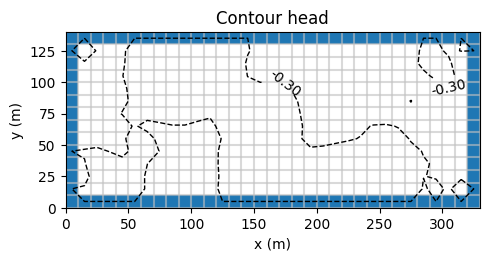

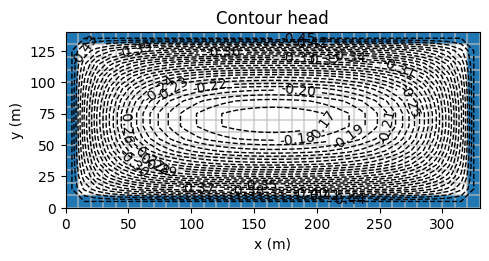

In [116]:
head_0 = gw_model2D(h0_boundary, recharge_0)
plt.figure()
head_1 = gw_model2D(h1_boundary, recharge_1)



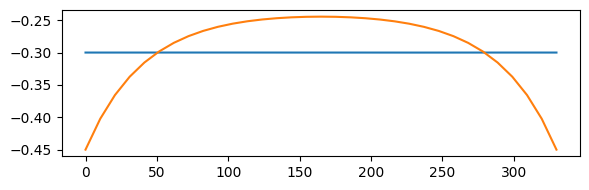

In [117]:
h0_middle = head_0[0][3, :]
h1_middle = head_1[0][3, :]
x = np.linspace(0, Lx, ncol)

fig, ax = plt.subplots(figsize=(6,2))
ax.plot(x, h0_middle)
ax.plot(x, h1_middle)

In [118]:
area = Lx * Ly
volume = area * recharge_1 #m3/d
volume_Ls = volume / 1000 / 24
volume_Ls

0.0019250000000000003

In [119]:
h1_avg = np.mean(head_1[0])

In [ ]:
h1_avg